In [1]:
import pandas as pd
import numpy as np
import statsmodels as sts
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
from concurrent.futures import ThreadPoolExecutor, as_completed
import seaborn as sns
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plot_summaries_path = './Data/plot_summaries.txt'
movie_metadata_path = './Data/movie.metadata.tsv'
character_metadata_path = './Data/character.metadata.tsv'
tv_tropes_path = './Data/tvtropes.clusters.txt'
name_clusters_path = './Data/name.clusters.txt'

In [4]:
plot_summaries = pd.read_csv(
    plot_summaries_path, sep='\t', header=None, names=['movie_wikipedia_id', 'plot_summary'])
movie_metadata = pd.read_csv(
    movie_metadata_path, sep='\t', header=None, 
    names=['movie_wikipedia_id', 'movie_freebase_id', 'movie_name', 
        'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres'])
character_metadata = pd.read_csv(
    character_metadata_path, sep='\t', header=None,
    names=['movie_wikipedia_id', 'movie_freebase_id', 'movie_release_date', 
           'character_name', 'actor_dob', 'actor_gender', 'actor_height', 
           'actor_ethnicity','actor_name','actor_age', 'character_freebase_map', 
           'freebase_character_id', 'freebase_actor_id'])
tv_tropes = pd.read_csv(tv_tropes_path, sep='\t', header=None, names=['trope', 'data'])
name_clusters = pd.read_csv(name_clusters_path, sep='\t', header=None, names=['character_name', 'id'])

Let's look at films with plots in the dataset

In [5]:
plots_and_metadata = pd.merge(movie_metadata, plot_summaries, on='movie_wikipedia_id')

In [6]:
print(f'There are {len(plots_and_metadata)} movies with plots')

There are 42204 movies with plots


# Merging with external datasets

The main goal of the project is to extract features from plots with LLM and investigate which of them can predict success of the movie.

Thus, we should focus on the films with plots.

We can define movie success based on reviews and box office.

## Reviews

The most overlap with CMU movies provides IMDB dataset from their website https://developer.imdb.com/non-commercial-datasets/

Let's download and unpack corresponding files (they are ~300 MB)

In [7]:
if not os.path.isdir('Data/imdb'):
    os.mkdir('Data/imdb')

In [8]:
%%capture
!wget -P Data/imdb https://datasets.imdbws.com/title.basics.tsv.gz
!wget -P Data/imdb https://datasets.imdbws.com/title.ratings.tsv.gz

!gunzip Data/imdb/title.basics.tsv.gz
!gunzip Data/imdb/title.ratings.tsv.gz

In [9]:
imdb_title_basics = pd.read_csv('Data/imdb/title.basics.tsv', sep='\t')
imdb_title_ratings = pd.read_csv('Data/imdb/title.ratings.tsv', sep='\t')

In [10]:
imdb_title_basics = imdb_title_basics[['tconst', 'primaryTitle']]

In [11]:
imdb_merged = pd.merge(imdb_title_ratings, imdb_title_basics, on='tconst')
imdb_merged = imdb_merged.drop(columns=['tconst']).drop_duplicates(subset=['primaryTitle'])

In [12]:
cmu_with_reviews = pd.merge(imdb_merged, plots_and_metadata, left_on='primaryTitle', right_on='movie_name', how='right')
cmu_with_reviews = cmu_with_reviews.drop(columns=['primaryTitle'])

In [13]:
notna_rating_frac = cmu_with_reviews['averageRating'].notna().mean()
print(f'We have average IMDB rating for {notna_rating_frac * 100:.0f}% of films')

We have average IMDB rating for 82% of films


## Budgets & Revenue

https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

In [14]:
bdgts = pd.read_csv("Data/movies_metadata.csv")
bdgts = bdgts[['budget', 'revenue', 'original_title']]

bdgts["budget"] = pd.to_numeric(bdgts['budget'], errors='coerce')
bdgts.dropna(subset=['budget'], inplace=True)
bdgts = bdgts.drop_duplicates(subset='original_title')

In [15]:
cmu_with_budgets = pd.merge(
    cmu_with_reviews, bdgts, left_on='movie_name', right_on='original_title', how='left') 

cmu_with_budgets['revenue'] = np.where(
    cmu_with_budgets['revenue_x'].notna(), 
    cmu_with_budgets['revenue_x'], 
    cmu_with_budgets['revenue_y']
)

cmu_with_budgets.drop(columns=['revenue_x', 'revenue_y', 'original_title'], inplace=True)

In [16]:
plots_and_metadata = cmu_with_budgets.copy(deep=True).rename(
    columns={'averageRating': 'avg_rating', 'numVotes': 'n_votes'})

In [17]:
notna_revenue_frac = cmu_with_budgets['revenue'].notna().mean()
print(f'We have average IMDB rating for {notna_revenue_frac * 100:.0f}% of films')

We have average IMDB rating for 45% of films


In [18]:
notna_budget_frac = cmu_with_budgets['budget'].notna().mean()
print(f'We have average IMDB rating for {notna_budget_frac * 100:.0f}% of films')

We have average IMDB rating for 41% of films


# Exploratory Data Analysis

## Exploring plot summaries

In [19]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


False

In [20]:
def process_plot_summary(record):
    # print(f'plot_processing on record: {record}')
    try:
        plot_summary = record['plot_summary']
        word_count = len(plot_summary.split())
        char_count = len(plot_summary)
        avg_word_length = word_count / char_count if char_count else 0
        sentence_count = len(nltk.sent_tokenize(plot_summary))
        lexical_diversity = len(set(plot_summary.split())) / word_count if word_count else 0
        sentiment_polarity = TextBlob(plot_summary).sentiment.polarity

        return {
            "movie_wikipedia_id": record['movie_wikipedia_id'],
            "word_count": word_count,
            "char_count": char_count,
            "avg_word_length": avg_word_length,
            "sentence_count": sentence_count,
            "lexical_diversity": lexical_diversity,
            "sentiment_polarity": sentiment_polarity
        }
    except Exception as e:
        print(f"An exception occurred: {e}")
        return None

In [21]:
results = []
records = plot_summaries.to_dict(orient='records')
failed = 0

with ThreadPoolExecutor(max_workers=12) as executor:
    future_to_record = {executor.submit(process_plot_summary, record): record for record in records}

    for future in as_completed(future_to_record):
        result = future.result()
        if result is not None:
            results.append(result)
        else:
            failed += 1

# Creating a new DataFrame from the processed data
processed_plot_summaries = pd.DataFrame(results)

processed_plot_summaries.head()

,movie_wikipedia_id,word_count,char_count,avg_word_length,sentence_count,lexical_diversity,sentiment_polarity
0,33059077,393,2384,0.164849,20,0.603053,0.072044
1,3790121,267,1657,0.161135,8,0.610487,0.086621
2,6009073,115,676,0.170118,5,0.800000,0.099219
3,1862086,439,2474,0.177445,21,0.553531,0.231599
4,4345210,220,1212,0.181518,11,0.609091,0.072419


In [22]:
processed_plot_summaries.describe()

,movie_wikipedia_id,word_count,char_count,avg_word_length,sentence_count,lexical_diversity,sentiment_polarity
count,4.230300e+04,42303.000000,42303.000000,42303.000000,42303.000000,42303.000000,42303.000000
mean,1.497051e+07,310.740468,1784.034229,0.173003,15.693071,0.669059,0.046343
std,1.111994e+07,318.338286,1808.925536,0.010850,16.605600,0.132991,0.136427
min,3.300000e+02,4.000000,99.000000,0.037736,1.000000,0.254916,-1.000000
25%,4.565802e+06,87.000000,508.000000,0.167692,4.000000,0.560569,-0.022222
50%,1.284591e+07,187.000000,1079.000000,0.173667,9.000000,0.666667,0.040330
75%,2.485168e+07,454.000000,2604.500000,0.179435,23.000000,0.766667,0.115984
max,3.750192e+07,4929.000000,28159.000000,0.239316,344.000000,1.000000,1.000000


Let's have an overview of created features

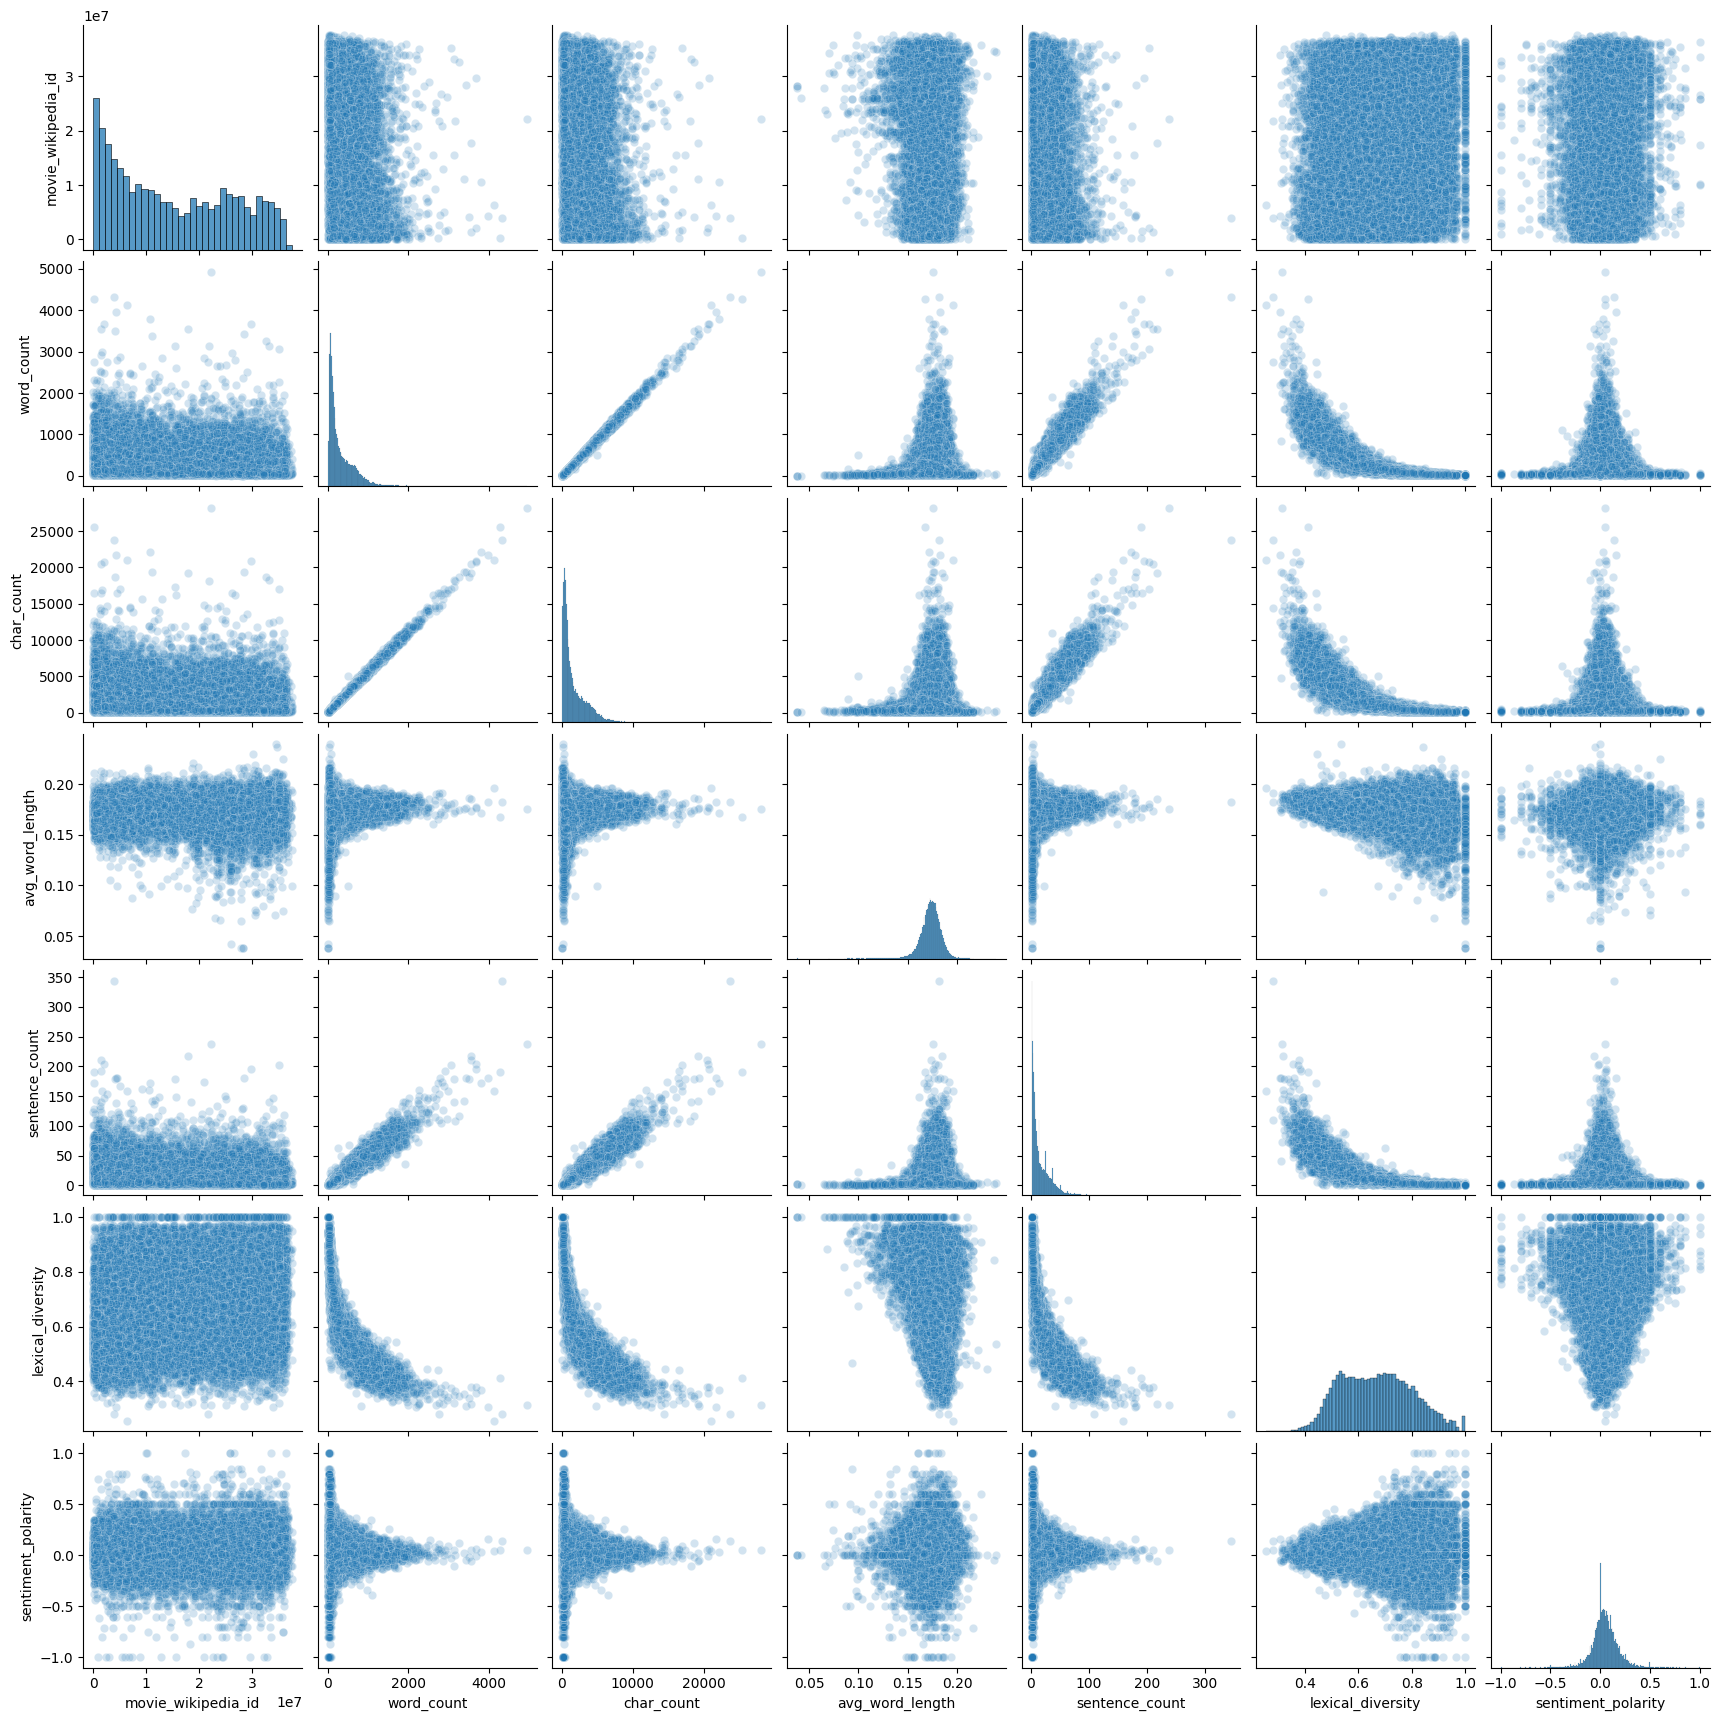

In [23]:
sns.pairplot(processed_plot_summaries, plot_kws={'alpha': 0.2})
plt.show()

The plot between word_count and lexical_diversity indicates that shorter summaries tend to have higher lexical diversity.

This could be due to a limitation of shorter texts where a few unique words make up a larger proportion of the text.

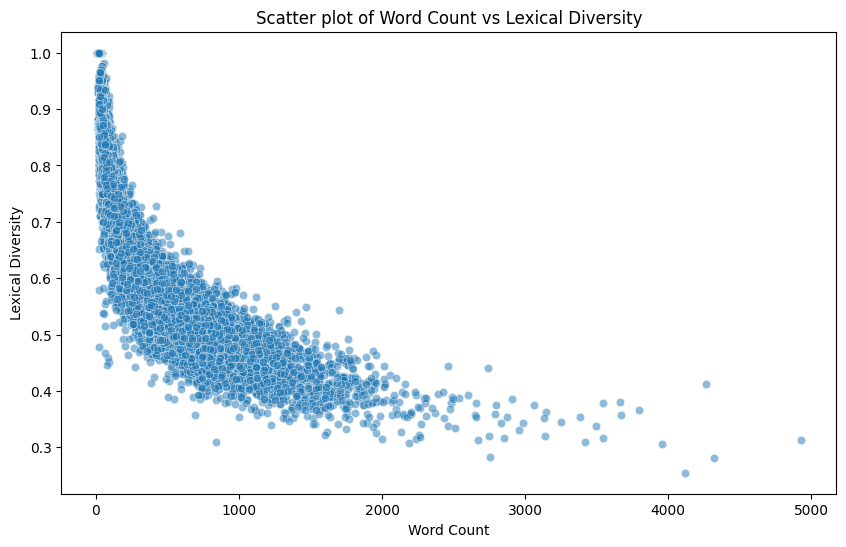

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='word_count', y='lexical_diversity', data=processed_plot_summaries, alpha=0.5)
plt.title('Scatter plot of Word Count vs Lexical Diversity')
plt.xlabel('Word Count')
plt.ylabel('Lexical Diversity')
plt.show()

The sentiment polarity distribution is centered around zero, which may indicate a balance of positive and negative sentiments in movie summaries. The scatter plots do not show strong correlations between sentiment polarity and other variables.

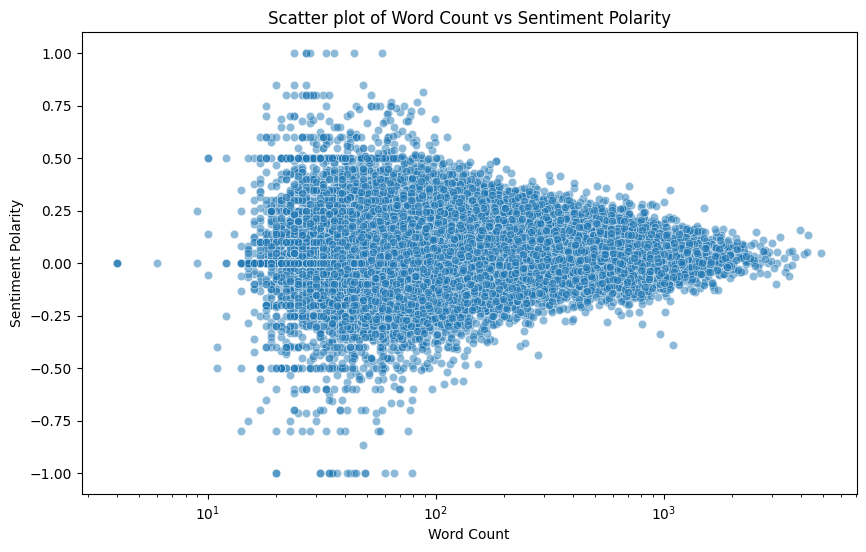

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='word_count', y='sentiment_polarity', data=processed_plot_summaries, alpha=0.5)
plt.title('Scatter plot of Word Count vs Sentiment Polarity')
plt.xlabel('Word Count')
plt.ylabel('Sentiment Polarity')
plt.xscale('log')  # Using log scale for word count if it's heavily skewed
plt.show()

## Exploring Movie Metadata

In [26]:
plots_and_metadata['release_date'] = plots_and_metadata['release_date'].astype(str)
plots_and_metadata['release_date'] = plots_and_metadata['release_date'].str.slice(0, 4)
plots_and_metadata['release_date'].replace('nan', np.nan, inplace=True)

In [27]:
# calculating % of missing data across all features
missing_percentage = plots_and_metadata.isna().mean() * 100
print("Percentage of Missing Values per Column:")
print(missing_percentage)

Percentage of Missing Values per Column:
avg_rating            18.282627
n_votes               18.282627
movie_wikipedia_id     0.000000
movie_freebase_id      0.000000
movie_name             0.000000
release_date           6.203203
runtime               15.695195
languages              0.000000
countries              0.000000
genres                 0.000000
plot_summary           0.000000
budget                58.529997
revenue               55.286229
dtype: float64


**Comment:** after merging with external data, 55% of box office revenue data is missing. We also lack information about runtime for approximately 15% of the movies. If we are to assign each movie to a year, we could either drop the columns missing release_date, or scrape the relevant information from online

Let's clean columns with json values: [] and {} might mean missing value, but it cannot be observed with `.isna()` method

In [28]:
values_to_replace = ['{}', '[]', '', 'NA', 'N/A', '-']
replace_map = {value: np.nan for value in values_to_replace}
movie_metadata_adj = plots_and_metadata.replace(replace_map)

missing_percentage_adj = movie_metadata_adj.isna().mean() * 100
print("Percentage of Missing Values per Column:")
print(missing_percentage_adj)

Percentage of Missing Values per Column:
avg_rating            18.282627
n_votes               18.282627
movie_wikipedia_id     0.000000
movie_freebase_id      0.000000
movie_name             0.000000
release_date           6.203203
runtime               15.695195
languages             12.472751
countries              7.847597
genres                 0.973841
plot_summary           0.000000
budget                58.529997
revenue               55.286229
dtype: float64


Let's check if we have duplicates and drop them

In [29]:
print(f'Rows before duplicate removal: {len(plots_and_metadata)}')

plots_and_metadata = plots_and_metadata.drop_duplicates(subset=['movie_wikipedia_id'], keep='first')
plots_and_metadata = plots_and_metadata.drop_duplicates(subset=['movie_freebase_id'], keep='first')

print(f'Rows after duplicate removal: {len(plots_and_metadata)}')

Rows before duplicate removal: 42204
Rows after duplicate removal: 42204


## Exploring Character Metadata

In [30]:
# calculating % of missing data across all features
missing_percentage = character_metadata.isna().mean() * 100
print("Percentage of Missing Values per Column:")
print(missing_percentage)

Percentage of Missing Values per Column:
movie_wikipedia_id         0.000000
movie_freebase_id          0.000000
movie_release_date         2.217814
character_name            57.220488
actor_dob                 23.552763
actor_gender              10.120288
actor_height              65.645740
actor_ethnicity           76.466542
actor_name                 0.272484
actor_age                 35.084064
character_freebase_map     0.000000
freebase_character_id     57.218269
freebase_actor_id          0.180842
dtype: float64


**Comments:** we have a lot of missing values across each feature

## Exploring TV Tropes

In [31]:
tv_tropes.head(10)

,trope,data
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."
5,adventurer_archaeologist,"{""char"": ""Indiana Jones"", ""movie"": ""Indiana Jo..."
6,adventurer_archaeologist,"{""char"": ""Indiana Jones"", ""movie"": ""Indiana Jo..."
7,adventurer_archaeologist,"{""char"": ""Indiana Jones"", ""movie"": ""Indiana Jo..."
8,adventurer_archaeologist,"{""char"": ""Evelyn Carnahan-O'Connell"", ""movie"":..."
9,arrogant_kungfu_guy,"{""char"": ""Han"", ""movie"": ""Enter the Dragon"", ""..."


Let's unpack `data` column which is in form of json

In [32]:
import json

tv_tropes['data'] = tv_tropes['data'].apply(json.loads)
expanded_data = tv_tropes['data'].apply(pd.json_normalize)

tv_tropes = tv_tropes.join(pd.concat(expanded_data.values).reset_index(drop=True))
tv_tropes.drop('data', axis=1, inplace=True)
tv_tropes = tv_tropes.rename(columns={'char': 'character_name', 'movie': 'movie_name', 'id': 'character_freebase_map', 'actor': 'actor_name'})

tv_tropes.head(10)

,trope,character_name,movie_name,character_freebase_map,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
5,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford
6,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Raiders of the Lost Ark,/m/0k294p,Harrison Ford
7,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Temple of Doom,/m/0jzx9b,Harrison Ford
8,adventurer_archaeologist,Evelyn Carnahan-O'Connell,The Mummy,/m/0k5yzc,Rachel Weisz
9,arrogant_kungfu_guy,Han,Enter the Dragon,/m/02vd8hn,Shih Kien


In [33]:
# calculating % of missing data across all features
missing_percentage = tv_tropes.isna().mean() * 100
print("Percentage of Missing Values per Column:")
print(missing_percentage)

Percentage of Missing Values per Column:
trope                     0.0
character_name            0.0
movie_name                0.0
character_freebase_map    0.0
actor_name                0.0
dtype: float64


# Extracting plot features with LLMs

The code below is adapted for Google Colab. It fits GPU and RAM and can be applied to the whole dataset when using batches, but due to the time constraints, we show its work for subsample

In [ ]:
def get_sample_lines(file_path, num_lines=5):
    with open(file_path, 'r', encoding='utf-8') as file:
        sample_lines = [next(file) for _ in range(num_lines)]
    return sample_lines

# Get the sample lines from the plot summaries file
sample_lines = get_sample_lines(plot_summaries_file, num_lines=15)

sample_plots = ['\t'.join(x.split('\t')[1:]).strip() for x in sample_lines]
plot_summaries_sample = plot_summaries.query('plot_summary in @sample_plots')

## llama

### Set up model

In [ ]:
%%capture
# # GPU llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

In [ ]:
# calling model

model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin" # the model is in bin format

In [ ]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama

In [ ]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

In [ ]:
# load the model

lcpp_llm = None
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=43, # Change this value based on your model and your GPU VRAM pool.
    n_ctx=4096, # Context window
    )

In [ ]:
# See the number of layers in GPU
lcpp_llm.params.n_gpu_layers

### Prompt methods

In [ ]:
def get_question(idx, key = "identify_topic", keywords_list = None):

    if key == "identify_topic":

        if keywords_list is None:
            question = (
            "Analyze the provided movie plot summary and identify the relevant themes present. "
            "Use the following fixed list of themes keywords for your analysis: Romance, Conflict, Adventure, "
            "Mystery, Comedy, Tragedy, Fantasy, Science Fiction, Horror, Drama, Action, Historical.\n"
            "List only those relevant themes that are present in this list. If a theme is not present, "
            "do not include it in your response. Your response should be a comma-separated list of single "
            "keywords, reflecting the themes found in the plot summary, with no additional information.\n"
            "Movie plot summary:\n"
            )

        else:
            question = (
            "Analyze the provided movie plot summary and identify the relevant themes present. "
            "Use the following fixed list of themes keywords for your analysis: ") + \
            ", ".join(keywords_list) + (
            ".\nList only those relevant themes that are present in this list. If a theme is not present, "
            "do not include it in your response. Your response should be a comma-separated list of single "
            "keywords, reflecting the themes found in the plot summary, with no additional information.\n"
            "Movie plot summary:\n"
            )
        return question + sample_lines[idx].split('\t')[1]

    elif key == "identify_mood":

        if keywords_list is None:
            question = (
            "Analyze the provided movie plot summary and identify the overall mood of the plot. "
            "Use the following fixed list of mood keywords for your analysis: "
            "Exciting, Dark, Lighthearted, Romantic, Inspirational, Dramatic, Fantastical.\n"
            "List only those relevant moods that are present in this list. If a mood is not present, "
            "do not include it in your response. Your response should be a comma-separated list of single "
            "keywords, reflecting the moods found in the plot summary, with no additional information.\n"
            "Movie plot summary:\n"
            )

        else:
            question = (
            "Analyze the provided movie plot summary and identify the relevant themes present. "
            "Use the following fixed list of themes keywords for your analysis: ") + \
            ", ".join(keywords_list) + (
            ".\nList only those relevant moods that are present in this list. If a mood is not present, "
            "do not include it in your response. Your response should be a comma-separated list of single "
            "keywords, reflecting the moods found in the plot summary, with no additional information.\n"
            "Movie plot summary:\n"
            )
        return question + sample_lines[idx].split('\t')[1]

    elif key == "identify_target_audience":

        if keywords_list is None:
            question = (
            "Analyze the provided movie plot summary and identify the target audience of the plot. "
            "Use the following fixed list of target audience types for your analysis: "
            "Children, Teenagers, Adults, Families, Elderly.\n"
            "Provide only one the most relevant target audience type that is present in this list. "
            "Do not provide a target audience type that is not present in the list. "
            "Your response should be just a word from the list with no additional information.\n"
            "Movie plot summary:\n"
            )

        else:
            question = (
            "Analyze the provided movie plot summary and identify the target audience of the plot. "
            "Use the following fixed list of target audience types for your analysis: ") + \
            ", ".join(keywords_list) + (
            ".\nProvide only one the most relevant target audience type that is present in this list. "
            "Do not provide a target audience type that is not present in the list. "
            "Your response should be just a word from the list with no additional information.\n"
            "Movie plot summary:\n"
            )
        return question + sample_lines[idx].split('\t')[1]

    elif key == "identify_temporal_setting":

        if keywords_list is None:
            question = (
            "Analyze the provided movie plot summary and identify the historical period of the plot. "
            "Use the following fixed list of historical period types for your analysis: "
            "past, modern, future.\n"
            "Provide only one the most relevant historical period type that is present in this list. "
            "Do not provide a historical period type that is not present in the list. "
            "Your response should be just a word from the list with no additional information.\n"
            "Movie plot summary:\n"
            )

        else:
            question = (
            "Analyze the provided movie plot summary and identify the historical period of the plot. "
            "Use the following fixed list of historical period types for your analysis: ") + \
            ", ".join(keywords_list) + (
            ".\nProvide only one the most relevant historical period type that is present in this list. "
            "Do not provide a historical period type that is not present in the list. "
            "Your response should be just a word from the list with no additional information.\n"
            "Movie plot summary:\n"
            )
        return question + sample_lines[idx].split('\t')[1]

    elif key == "identify_location_setting":

        if keywords_list is None:
            question = (
            "Analyze the provided movie plot summary and identify the primary geographical setting of the plot. "
            "Use the following fixed list of geographical setting types for your analysis: "
            "real, fictional.\n"
            "Provide only one the most relevant geographical setting type that is present in this list. "
            "Do not provide a geographical settingd type that is not present in the list. "
            "Your response should be just a word from the list with no additional information.\n"
            "Movie plot summary:\n"
            )

        else:
            question = (
           "Analyze the provided movie plot summary and identify the primary geographical setting of the plot. "
            "Use the following fixed list of geographical setting types for your analysis: ") + \
            ", ".join(keywords_list) + (
            ".\nProvide only one the most relevant geographical setting type that is present in this list. "
            "Do not provide a geographical settingd type that is not present in the list. "
            "Your response should be just a word from the list with no additional information.\n"
            "Movie plot summary:\n"
            )
        return question + sample_lines[idx].split('\t')[1] # sample_lines[idx].split('\t')[1] is a str with plot summary

    else:
        raise ValueError("key should be from the following list: identify_topic, "
                         "identify_mood, identify_target_audience, identify_temporal_setting, "
                         "identify_location_setting")

In [ ]:
def ask_prompt(prompt):
    response=lcpp_llm(prompt=prompt, max_tokens=512, temperature=1, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)
    return response

In [ ]:
def form_prompt(idx, key, keywords_list = None):
  question = get_question(idx, key, keywords_list)
  initial_prompt=f'''\nSYSTEM: You are a helpful, respectful and honest assistant. Always answer as helpfully.
\nUSER: {question}

ASSISTANT:
  '''
  return initial_prompt

In [ ]:
import re

def extract_keywords(response, keywords_list):
    """
    Extracts keywords present in a response based on a predefined list.

    Parameters:
    response (str): The response from the LLM.
    keywords_list (list): The list of predefined keywords.

    Returns:
    list: A list of keywords present in the response that are also in the predefined list.
    """
    # Create a pattern from the keywords list, joined by '|'
    pattern = '|'.join(keywords_list)

    # Find all occurrences of the keywords in the response using regex
    found_keywords = re.findall(pattern, response, re.IGNORECASE)

    # Return the unique keywords found, avoiding duplicates and preserving the order
    unique_keywords = []
    for keyword in found_keywords:
        if keyword.lower() not in (t.lower() for t in unique_keywords):
            unique_keywords.append(keyword.lower())

    return unique_keywords



In [ ]:
keywords_dist = {"identify_topic": ["Romance", "Conflict", "Adventure", "Mystery", "Comedy",
                                    "Tragedy", "Fantasy", "Science Fiction", "Horror", "Drama",
                                    "Action", "Historical"],

                "identify_mood": ["Exciting", "Dark", "Lighthearted", "Romantic",
                                "Inspirational", "Dramatic", "Fantastical"],

                "identify_target_audience": ["Children", "Teenagers", "Adults", "Families", "Elderly"],

                "identify_temporal_setting": ["past", "modern", "future"],

                "identify_location_setting": ["real", "fictional"]}


# key = "identify_mood"
# output = ask_prompt(form_prompt(idx = 1, key = key, keywords_list = keywords_dist[key]))

In [ ]:
from tqdm.auto import tqdm
from collections import defaultdict
response_dict = defaultdict(list)

for key, keyword_list in tqdm(keywords_dist.items()):
  for i in range(len(sample_lines)):
    output = ask_prompt(form_prompt(idx=i, key=key, keywords_list=keyword_list))
    response = output['choices'][0]["text"].split("ASSISTANT:")[1].strip()
    extracted_keywords = extract_keywords(response, keywords_dist[key])
    response_dict[key].append(','.join(extracted_keywords))

In [ ]:
for new_col, new_values in response_dict.items():
    plot_summaries_sample[new_col] = new_values

## BERT

In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline, BertTokenizer, AutoModelForSequenceClassification

class SentimentExtractionModel():
    def __init__(self, sentiment_model_name = "nlptown/bert-base-multilingual-uncased-sentiment",
                 emotion_model_name = "bhadresh-savani/distilbert-base-uncased-emotion"):

        self.sentiment_model_name = sentiment_model_name
        self.emotion_model_name = emotion_model_name

        self.auxilary_tokenizer = BertTokenizer.from_pretrained(sentiment_model_name)

        self.sentiment_model = pipeline("sentiment-analysis", model=sentiment_model_name)
        self.emotion_model = pipeline("sentiment-analysis", model=emotion_model_name)

    def analyze_sentiment(self, plot_summary: str):

        truncated_text = self.truncate_text(plot_summary)

        return self.sentiment_model(truncated_text)[0]['label']

    def analyze_emotion(self, plot_summary: str):

        truncated_text = self.truncate_text(plot_summary)

        return self.emotion_model(truncated_text)[0]['label']

    def truncate_text(self, text: str):

        encoded_text = self.auxilary_tokenizer.encode(text, add_special_tokens=True,
                                                      max_length=510, truncation=True)

        return self.auxilary_tokenizer.decode(encoded_text)

In [ ]:
sentiment_extraction_model = SentimentExtractionModel()

In [ ]:
from tqdm.auto import tqdm
sentiments = list()
for line in tqdm(sample_lines):
    idx, summary = line.split('\t')
    sentiment = sentiment_extraction_model.analyze_sentiment(summary)
    sentiments.append(sentiment)

In [ ]:
emotions = list()
for line in tqdm(sample_lines):
    idx, summary = line.split('\t')
    emotion = sentiment_extraction_model.analyze_emotion(summary)
    emotions.append(emotion)

In [ ]:
plot_summaries_sample['sentiment'] = sentiments
plot_summaries_sample['emotion'] = emotions

In [ ]:
plot_summaries_sample.to_csv('plot_summaries_with_features_sample.csv')